# **Mô tả bài toán Phân tích cảm nhận của người xem phim (Sentiment Analysis of Movie Reviews)**
## Mục đích của bài toán:
#### Với mỗi bình luận của người xem model phải xác định được bình luận đó là tiêu cực hay tích cực.

#### Ta sẽ sử dụng bộ dữ liệu đánh giá phim từ trang web IMDb (Cơ sở dữ liệu phim trên Internet) do nhà nghiên cứu Andrew Maas của Stanford thu thập.Tập dữ liệu này chứa nội dung của các bài đánh giá, cùng với nhãn cho biết một bài đánh giá là “tích cực” hay “tiêu cực”. Bản thân trang web IMDb chứa xếp hạng từ 1 đến 10. Để đơn giản hóa mô hình, chú thích này được tóm tắt dưới dạng tập dữ liệu phân loại hai lớp trong đó các bài đánh giá có điểm từ 6 trở lên được gắn nhãn là tích cực và phần còn lại là tiêu cực. 

# Khảo sát dữ liệu
### Cấu trúc dataset file http://ai.stanford.edu/~amaas/data/sentiment/
#### Gồm 2 thư mục :
#### + Pos folder chứa toàn bộ bình luận tích cực
#### + Neg folder chứa toàn bộ bình luận tiêu cực
#### Mỗi folder là các file .txt riêng rả chứa bình luận


In [4]:
import seedir as sd
sd.seedir('./aclImdb_v2/aclImdb/',depthlimit=2)

aclImdb/
├─imdb.vocab
├─imdbEr.txt
├─README
├─test/
│ ├─neg/
│ └─pos/
└─train/
  ├─neg/
  └─pos/


#### Load dữ liệu từ bộ dữ liệu 

In [5]:
from sklearn.datasets import load_files
import numpy as np

reviews_train = load_files("aclImdb_v2/aclImdb/train/")

### Tách nhãn và dữ liệu từ bộ dữ liệu

In [6]:
# load_files returns a bunch, containing training texts and training labels
text_train, y_train = reviews_train.data, reviews_train.target
print("Kiểu dữ liệu của text_train: {}".format(type(text_train)))
print("Số lượng dữ liệu của text_train: {}".format(len(text_train)))
reviews_train.target

Kiểu dữ liệu của text_train: <class 'list'>
Số lượng dữ liệu của text_train: 25000


array([1, 0, 1, ..., 0, 0, 0])

### Số lượng dữ liệu 2 nhãn positive và negative

Samples per class (test): [12500 12500]


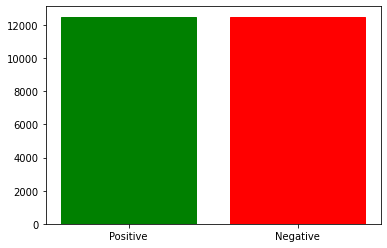

In [7]:
import collections
import matplotlib.pyplot as plt

print("Samples per class (test): {}".format(np.bincount(y_train)))

count = collections.Counter(y_train)
x = np.array(["Positive", "Negative"])
y = np.array([count[1], count[0]])

barlist = plt.bar(x,y)
barlist[0].set_color('g')
barlist[1].set_color('r')
plt.show()

# Lựa chọn mô hình cho bài toán
### Mục tiêu của bài toán như sau 
###   *B1 : Đưa ra một đánh giá*
###   *B2 : Đánh giá nội dung là tích cực hay tiêu cực rồi gán nhãn “positive” or “negative” cho chúng*
### Ta có thể thấy đây là một nhiệm vụ phân loại nhị phân tiêu chuẩn.

![alt text](./images/th2.jpeg "Title")

### Tuy nhiên, dữ liệu văn bản không ở định dạng mà mô hình máy học có thể xử lý. 
### Vậy nên ta cần xử lý ***ngôn ngữ tự nhiên (Natural Language Processing - NLP)***
### <font color='red'>  **=> Cần chuyển đổi biểu diễn chuỗi của văn bản thành biểu diễn số**</font>

### Một trong những cách đơn giản nhưng hiệu quả và thường được sử dụng để xử lý ngôn ngữ tự nhiên là sử dụng biểu diễn túi từ (Bag of Words) 
***
### <font color="yellow">Nguyên lý</font>: Bất kỳ thông tin nào về thứ tự hoặc cấu trúc của các từ trong câu đều bị loại bỏ, chỉ quan tâm đến việc các từ đã biết có xuất hiện trong tài liệu hay không, chứ không phải ở vị trí nào trong tài liệu.
***


### Tính toán biểu diễn túi từ cho một bộ dữ liệu bao gồm các ba bước sau:
![alt text](./images/Picture.png "Title")

### Tiền xử lý dữ liệu (Data pre-processing)

In [8]:
text_train = [doc.decode('utf-8') for doc in text_train]
print((text_train[0]))

Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty.


### Làm sách xóa các (tag < br />).  trong dữ liệu

In [9]:
import re
def clean(text):
    cleaned = re.compile(r'<.*?>')
    return re.sub(cleaned,'',text)


text_train = [clean(doc) for doc in text_train]
print(text_train[0])


Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. Flawed but honest with a terrible honesty.


### Xóa các ký hiệu đặc biệt trong dữ liệu

In [10]:
def is_special(text):
    rem = ''
    for i in text:
        if i.isalnum():
            rem = rem + i
        else:
            rem = rem + ' '
    return rem

text_train = [is_special(doc) for doc in text_train]
print(text_train[0])


Zero Day leads you to think  even re think why two boys young men would do what they did   commit mutual suicide via slaughtering their classmates  It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own mutual world via coupled destruction It is not a perfect movie but given what money time the filmmaker and actors had   it is a remarkable product  In terms of explaining the motives and actions of the two young suicide murderers it is better than  Elephant    in terms of being a film that gets under our  rationalistic  skin it is a far  far better film than almost anything you are likely to see  Flawed but honest with a terrible honesty 


### lowercase dữ liệu

In [11]:
def to_lower(text):
    return text.lower()

text_train = [to_lower(doc) for doc in text_train]
text_train[0]

'zero day leads you to think  even re think why two boys young men would do what they did   commit mutual suicide via slaughtering their classmates  it captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own mutual world via coupled destruction it is not a perfect movie but given what money time the filmmaker and actors had   it is a remarkable product  in terms of explaining the motives and actions of the two young suicide murderers it is better than  elephant    in terms of being a film that gets under our  rationalistic  skin it is a far  far better film than almost anything you are likely to see  flawed but honest with a terrible honesty '

### Sử dụng hàm có sắn của sklearn áp dụng túi từ (Bag-of-Words) cho bài toán , sử dụng stop_words để loại bỏ các stop words (i, me, thick, most, anything,...) trong tiếng anh.

In [12]:
from sklearn.datasets import load_files
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(min_df=5, stop_words="english").fit(text_train)
X_train = vect.transform(text_train)

print("X_train:\n{}".format(repr(X_train)))

X_train:
<25000x26960 sparse matrix of type '<class 'numpy.int64'>'
	with 2149105 stored elements in Compressed Sparse Row format>


In [13]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

first_X_train = X_train[0]
print(first_X_train.toarray())

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

### <font color='red'>  ***Đối với dữ liệu nhiều chiều, rải rác như thế này, các mô hình tuyến tính như ***Logistic Regression*** thường hoạt động tốt nhất.*** </font>
***
#### ***Logistic Regression*** được áp dụng trong bài toán phân loại nhị phân (Binary classification) tức ta sẽ có hai output, hoặc có thể gọi là hai nhãn (ví dụ như 0 và 1 hoặc positive và negative).
#### ***Logistic Regression*** thường được sử dụng để so sánh với các thuật toán phân loại khác.
#### ***Logistic Regression*** là 1 thuật toán phân loại được dùng để dự đoán giá trị dữ liệu dựa trên các quan sát trước đó của tập dữ liệu.
#### Input: dữ liệu input (ta sẽ coi có hai nhãn là 0 và 1).
#### Output : Xác suất dữ liệu input rơi vào nhãn 0 hoặc nhãn 1.
![alt text](./images/logistic-300x262-1.jpg "Title")
***

# Huấn luyện mô hình Logistic Regression

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

c:\Users\Admin\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

### Ta làm tương tự với lần lượt 3 mô hình nhị phân phổ biến khác là Sgd (Stochastic Gradient Descent) , Decision Tree , K-Nearest Neighbors

In [15]:
from sklearn.linear_model import SGDClassifier


model_1 = SGDClassifier()
model_1.fit(X_train, y_train)


SGDClassifier()

In [16]:
from sklearn.tree import DecisionTreeClassifier

model_2 = DecisionTreeClassifier()
model_2.fit(X_train, y_train)

DecisionTreeClassifier()

In [17]:
from sklearn.neighbors import KNeighborsClassifier

# n_neighbors = sqrt(n) / 2
# n : số lượng dữ liệu
model_3 = KNeighborsClassifier(n_neighbors=79)
model_3.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=79)

# Đánh giá mô hình

### Ta đánh giá dựa trên các tiêu chí:

### ***Accuracy***
### Accuracy (độ chính xác) chỉ đơn giản đánh giá mô hình thường xuyên dự đoán đúng đến mức nào. Độ chính xác là tỉ lệ giữa số điểm dữ liệu được dự đoán đúng và tổng số điểm dữ liệu.
![alt text](./images/accuracy_total.png "Title")


### ***Confusion Matrix***
### Một phương pháp tốt hơn để đánh giá performance của mô hình phân lớp đó là confusion matrix (ma trận nhầm lẫn). Ý tưởng chính là đếm số lần phần tử thuộc class A bị phân loại nhầm vào class B.
### Confusion matrix cung cấp thêm thông tin về tỉ lệ phân lớp đúng giữa các lớp, hay giúp phát hiện các lớp có tỉ lệ phân lớp nhầm cao nhờ vào các khái niệm True (False) Positive (Negative)
![alt text](./images/confusion_total.jpg "Title")

### Ví dụ đối với mô hình Logistic Regression, chúng ta có thể biểu diễn kết quả dự đoán của mô hình bằng confusion matrix như sau:

### True Positive TP = 10806: 10806 bình luận tốt (positive) được mô hình phân loại đúng.
### False Positive FP = 1694: có 1694 bình luận xấu, nhưng được mô hình phân loại là bình luận tốt.
### True Negative TN = 10580: 10580 bình luận xấu (negative) được mô hình phân loại đúng.
### False Negative FN = 1920: có 1920 bình luận tốt nhưng được mô hình phân loại là bình luận xấu.

### ***Precision và Recall***
### Với những thông tin có được từ Confusion matrix, chúng ta có thể định lượng độ hiệu quả của mô hình qua nhiều thang đo khác nhau. Precision và Recall là hai thang đo quan trọng trong số đó.

### Precision và Recall có giá trị trong [0,1], hai giá trị này càng gần với 1 thì mô hình càng chính xác. 
### Precision càng cao đồng nghĩa với các điểm được phân loại càng chính xác. 
### Recall càng cao cho thể hiện cho việc ít bỏ sót các điểm dữ liệu đúng.
![alt text](./images/precision_recall_total.jpg "Title")

### ***F1-Score***
### Một mô hình tốt khi cả Precision và Recall đều cao, thể hiện cho mô hình ít phân loại nhầm giữa các lớp cũng như tỉ lệ bỏ sót các đối tượng thuộc lớp cần quan tâm là thấp. Tuy nhiên, hai giá trị Precision và Recall thường không cân bằng với nhau (giá trị này tăng thì giá trị kia thường có xu hướng giảm). Để đánh giá cùng lúc cả Precision và Recall, ta sử dụng độ đo F-Score
![alt text](./images/fscore_formula.jpg "Title")

### Tham số β quyết định mức độ coi trọng giữa Precision và Recall

###  β > 1: Recall được coi trọng hơn Precision
###  β < 1: Precision được coi trọng hơn Recall
###  β = 1: Precision và Recall được coi trọng ngang nhau

![alt text](./images/f1_total.jpg "Title")

### ***ROC curve***
### là một đường cong biểu diễn hiệu suất phân loại của một mô hình phân loại tại các ngưỡng threshold.Về cơ bản, nó hiển thị True Positive Rate (TPR) so với False Positive Rate (FPR) đối với các giá trị ngưỡng khác nhau.

### Có rất nhiều mô hình phân loại mang tính xác suất, ví dụ dự doán xác suất của một mẫu là Cat. Chúng so sánh xác suất đầu ra với một số ngưỡng giới hạn và nếu nó lớn hơn ngưỡng đó, mô hình dự đoán nhãn là Cat, còn không thì là Non-cat.

### Ví dụ mô hình của bạn dự đoán giá trị xác suất cho 4 samples lần lượt là [0.45, 0.6, 0.7, 0.3]. Tùy vào giá trị ngưỡng mà sẽ có các nhãn đầu ra dự đoán khác nhau:

### Ngưỡng là 0.5: Sample 2,3 là Cat
### Ngưỡng là 0.25: Tất cả samples đều là Cat
### Ngưỡng là 0.8: Tất cả sample là Non-cat
### Có thể thấy với các ngưỡng khác nhau, chúng ta sẽ có kết quả dự đoán nhãn khác nhau, kéo theo các giá trị như precision hay recall cũng sẽ khác nhau

![alt text](./images/roc_total.jpg "Title")

### ***AUC*** là phần diện tích bên dưới ROC curve, dùng để đánh giá hiệu năng phân loại của các mô hình với nhau. Mô hình có AUC càng lớn (ROC curve càng gần góc cao bên trái) thì cho kết quả càng chính xác. Ngược lại, mô hình có ROC curve càng tiến tới đường chéo 45 độ (đường gạch đứt màu xanh ở hình trên), tức AUC càng thấp thì kết quả càng tệ. AUC càng cao thì mô hình càng dễ phân loại đúng cho cả lớp positive và negative.
![alt text](./images/roc3.png "Title")

## <font color="yellow"> => Sau lần lượt các đánh giá ta chọn mô hình ***Logistic Regression*** là mô hình tốt nhất trong 4 mô hình huấn luyện cho bài toán phân tích cảm nhận của người xem phim (Sentiment Analysis of Movie Reviews) </font>

# Ứng dụng

### Xuất mô hình , vect trích chọn với thư viện pickle

In [18]:
import pickle
filename = "finalized_model.pkl"
with open(filename, 'wb') as fout:
    pickle.dump((vect, model), fout)

### Ví dụ với một bình luận bất kỳ

In [25]:
str="Bad movie.I don't recommend you watch this , you will waste your time and money , trust me !"
print("Review: " + str)

# tiền xử lý
f1 = clean(str)
f2 = is_special(f1)
f3 = to_lower(f2)

array = []
array.append(f3)

# Trích chọn
user_test = vect.transform(array)

# Dự đoán
y_pred_user = model.predict(user_test)

if y_pred_user == 0:
    print("Guess: Negative review")
else:
    print("Guess: Positive review")

Review: Bad movie.I don't recommend you watch this , you will waste your time and money , trust me !
Guess: Negative review
